# GNN GAT Explainer

## Graph Data Prep

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
benign = {
    'Tcells':{'up': ['CD3D','LCK','ZAP70'],'down': ['CD19']},
    'Bcells':{'up': ['CD19'],'down': ['CD3D','LCK','ZAP70']},
  #  'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

cancerous = {
    'Tcells':{'up': ['CD3D','ZAP70'],'down': ['CD19','LCK']},
    'Bcells':{'up': ['CD19','LCK','CD3D'],'down': ['ZAP70']},
   # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
}

# cancerous_2 = {
#     'Tcells':{'up': ['ZAP70'],'down': ['CD19','CD3D','LCK']},
#     'Bcells':{'up': ['CD19','CD3D'],'down': ['LCK','ZAP70']},
#    # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
# }

# cancerous_3 = {
#     'Tcells':{'up': ['LCK'],'down': ['ZAP70','CD19','CD3D']},
#     'Bcells':{'up': ['CD19','ZAP70'],'down': ['LCK','CD3D']},
#    # 'Macrophages':{'up': ['CSF1R'],'down': ['CD3D','MS4A1','CD19']},
# }
graphs = [benign, cancerous] #, cancerous_2, cancerous_3]

In [4]:
cell_types = ['Tcells','Bcells']
genes = ['CD3D','LCK','ZAP70','CD19'] #only focused on genes present
node_order = genes + [f'CT_{ct}' for ct in cell_types]   # genes first, then CT nodes
gene_mask = torch.tensor([1,1,1,1,0,0], dtype=torch.bool)
N = len(node_order) 

In [5]:
def build_vocab(genes, cell_types):
    toks = genes + [f'CT_{ct}' for ct in cell_types]
    stoi = {t:i for i,t in enumerate(toks)}; itos = {i:t for t,i in stoi.items()}
    return stoi, itos

stoi, itos = build_vocab(genes, cell_types)
vocab_size = len(stoi)

vocab_size, stoi

(6,
 {'CD3D': 0, 'LCK': 1, 'ZAP70': 2, 'CD19': 3, 'CT_Tcells': 4, 'CT_Bcells': 5})

In [6]:
def make_graph_signed(spec):
    N = len(node_order); 
    A_signed = torch.zeros(N, N)
    def idx(n): 
        return node_order.index(n)
    def add_edge(g, ct, s):
        i, j = idx(g), idx(f"CT_{ct}")
        A_signed[i,j] = s
        A_signed[j,i] = s
    for ct in cell_types:
        for g in spec[ct].get('up', []):   
            add_edge(g, ct, +1)
        for g in spec[ct].get('down', []): 
            add_edge(g, ct, -1)
    # labels for node task (0=T, 1=B) on genes only
    y_node = torch.full((N,), -1, dtype=torch.long)
    X = torch.tensor([stoi[n] for n in node_order], dtype=torch.long)
    
    # per-gene cell-type label: 0=Tcells, 1=Bcells (prefer UP, tie-break T→B, fallback from DOWN)
    y_node = torch.full((N,), -1, dtype=torch.long)
    for g in genes:
        t_up = g in spec['Tcells'].get('up', [])
        b_up = g in spec['Bcells'].get('up', [])
        t_dn = g in spec['Tcells'].get('down', [])
        b_dn = g in spec['Bcells'].get('down', [])
        lab = None
        if t_up and not b_up: 
            lab = 0
        elif b_up and not t_up: 
            lab = 1
        elif t_up and b_up: 
            lab = 0
        else:
            if t_dn and not b_dn: 
                lab = 1
            elif b_dn and not t_dn: 
                lab = 0
        if lab is not None: 
            y_node[idx(g)] = lab
    return X, y_node, A_signed

In [7]:
x_list, y_node_list, a_list = [], [], []
for spec in graphs:
    X_i, y_i, A_i = make_graph_signed(spec)
    x_list.append(X_i); y_node_list.append(y_i); a_list.append(A_i)

x_list, y_node_list, a_list

([tensor([0, 1, 2, 3, 4, 5]), tensor([0, 1, 2, 3, 4, 5])],
 [tensor([ 0,  0,  0,  1, -1, -1]), tensor([ 0,  1,  0,  1, -1, -1])],
 [tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 1.,  1.,  1., -1.,  0.,  0.],
          [-1., -1., -1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0.,  1.,  1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 1., -1.,  1., -1.,  0.,  0.],
          [ 1.,  1., -1.,  1.,  0.,  0.]])])

**x_tokens** - a list of nodes

Notice that all nodes are present in each of our samples. 

In [8]:
x_tokens = torch.stack(x_list)
x_tokens.size(), x_tokens

(torch.Size([2, 6]),
 tensor([[0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5]]))

**y_node** - per-node (gene) gene cell type labels. This uses a balance of the up-regulated and down-regulated genes and flags for each sample. If the gene is more commonly upregulated with B-cells we flag it as `0` and if it's more commonly up-regulated in T-cells we flag it as `1`.  This evaluation is done per sample (seen here as per row). 

The last two columns are embeddings purely for cell type so we flag them as -1 to be masked during training. 

In [9]:
y_node = torch.stack(y_node_list)
y_node.size(), y_node

(torch.Size([2, 6]),
 tensor([[ 0,  0,  0,  1, -1, -1],
         [ 0,  1,  0,  1, -1, -1]]))

**y_graph** - per-graph (sample) cancer type label. We use `1` for cancerous and `0` for benign

In [10]:
y_graph = torch.tensor([0,1])  # 0=wild, 1=cancer
y_graph.size(), y_graph

(torch.Size([2]), tensor([0, 1]))

**Graph** 

Since this is a GNN explainer, let's visualize actually how these graphs look. This is in essence the graph the model is looking at and learning how to read so that if it sees a new one, it can predict the properties we are minimizing loss on (cancerous, cell type). 

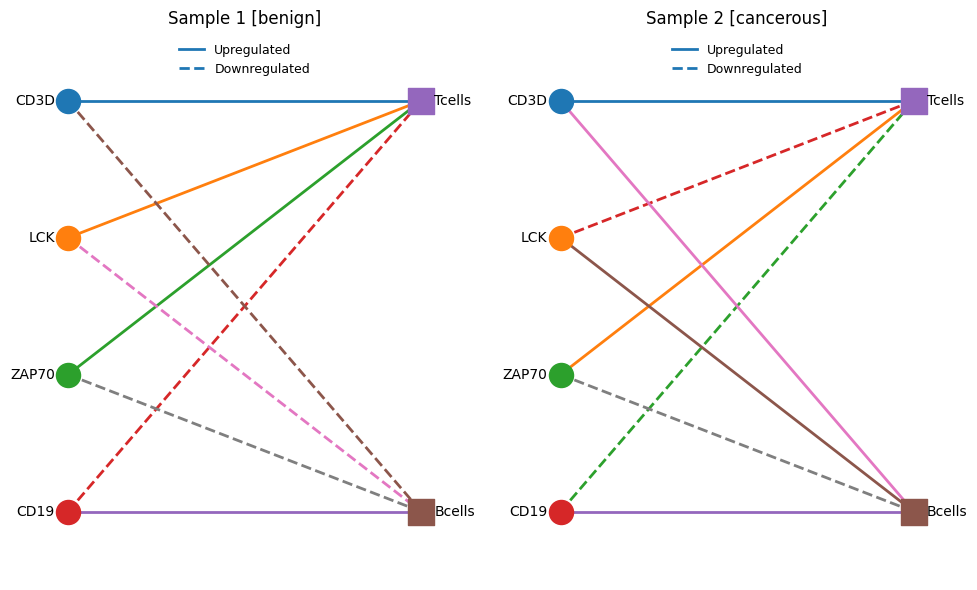

In [17]:
def compute_positions(genes, cell_types):
    # left column (genes), right column (cell types)
    gx, cx = 0.1, 0.9
    gy = list(range(len(genes)-1, -1, -1))  # top-to-bottom
    if len(cell_types) > 1:
        # spread CTs across same vertical span as genes
        span = (len(genes)-1)
        cy = [span * (1 - i/(len(cell_types)-1)) for i in range(len(cell_types))]
    else:
        cy = [(len(genes)-1)/2]
    pos = {g:(gx, gy[i]) for i,g in enumerate(genes)}
    pos.update({f"CT_{ct}":(cx, cy[j]) for j,ct in enumerate(cell_types)})
    return pos

def draw_sample(ax, spec, title, genes, cell_types):
    pos = compute_positions(genes, cell_types)
    # draw nodes
    for i,g in enumerate(genes):
        x,y = pos[g]
        ax.scatter([x],[y], s=300, marker='o', zorder=3)
        ax.text(x-0.03, y, g, va='center', ha='right', fontsize=10)
    for ct in cell_types:
        name = f"CT_{ct}"
        x,y = pos[name]
        ax.scatter([x],[y], s=350, marker='s', zorder=3)
        ax.text(x+0.03, y, ct, va='center', ha='left', fontsize=10)
    # draw edges: solid = upregulated (+1), dashed = downregulated (-1)
    for ct in cell_types:
        ct_name = f"CT_{ct}"
        for g in spec[ct].get('up', []):
            if g in genes:
                x1,y1 = pos[g]; x2,y2 = pos[ct_name]
                ax.plot([x1,x2],[y1,y2], linestyle='-', linewidth=2, zorder=2)
        for g in spec[ct].get('down', []):
            if g in genes:
                x1,y1 = pos[g]; x2,y2 = pos[ct_name]
                ax.plot([x1,x2],[y1,y2], linestyle='--', linewidth=2, zorder=2)

    # aesthetics
    ax.set_title(title)
    ax.set_xlim(0.0, 1.0)
    ys = list(range(len(genes)))
    ax.set_ylim(-0.5, len(genes)-0.5)
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values(): spine.set_visible(False)

    # legend (solid=up, dashed=down)
    from matplotlib.lines import Line2D
    legend_lines = [
        Line2D([0],[0], linestyle='-', linewidth=2, label='Upregulated'),
        Line2D([0],[0], linestyle='--', linewidth=2, label='Downregulated'),
    ]
    ax.legend(handles=legend_lines, loc='upper center', frameon=False, fontsize=9)

# ----- draw all four samples -----
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
samples = [
    ('Sample 1 [benign]',    benign),
    ('Sample 2 [cancerous]',    cancerous),
    #('Sample 3 [cancerous]',  cancerous_2),
    #('Sample 4 [cancerous]',  cancerous_3),
]
for ax, (name, spec) in zip(axes.ravel(), samples):
    draw_sample(ax, spec, name, genes, cell_types)

plt.tight_layout()
plt.show()

# Modeling

A machine learning model forward pass now uses the data prep information, runs several layers of linear algebra on it, and then "predicts" the probability of our different tasks, in this case the cell type based on the node and whether a graph is cancerous. When it is noisy (like you will see in this example), this process results in gibberish.  The training process changes the noise to pattern during the "backward pass" as you'll see. We'll show 3 steps that are focused on training:
1. **Data Loading** - this step pulls from the raw data enough examples and batches to complete a forward pass and loss calculation.  If the model is inference only, this step is replaced with taking in the inference input and preparing it similarly as the forward pass. 
2. **Forward Pass** - using the data and the model architecture we run a prediction for the tokens. When training we also compare against the expected to get loss, but in inference, we use the logits to complete the inference task.
3. **Back Propagation, aka Backward Pass & Training** - using differentials we can understand what parameters most drive the difference between forward pass' impact on its prediction versus what is actually right based on the data loading step. We compare this based on the loss function and use the partial derivative gradients to make very minor adjustments to the impactful parameters with the hope it improves future predictions.

After our back prop, we'll show a final **Forward Pass** with the updated weights we did in #3 and then convert those final weights to a **Model Inference**

## Data Loading

To start, we need to get enough data to run the forward and backward passes.  Since our total dataset in a real experiment is likely too big to be held in memory all at once in real practice, we will read just enough file information into memory so that we can run the passes, leaving memory and compute to be used on the passes instead of static data holding. 
To start, we have to identify the batch size and the model context length to determine how much data we need.  Consequently, these dimensions also form 2 of the 3 dimensions in the initial matrix.
- **Batch Size (B)** - This is the number of examples you'll train on in a single pass. 
- **Number of Nodes (N)** - This is basically the "context length" for a GNN.  This is the max number of nodes that a model can use in a pass.

Beyond these, in a GCN, the depth also controls how much context, or complexity, can be learned. This is because each GCN layer learns 1 hop, or 1 relationship of neighbors. This means that after $L$ layers, a model can learn $L$-hops worth of context.

In our case we'll set our batch to be our 4 examples, and nodes to the nodes we have configured, 6. As we walk through you'll also see our GCN will have 2 layers to model 2 network hops: gene > cell type > other genes.

We'll prepare 2 sets of data. Our **Inputs** will be the `x_token`, or our list of nodes for each example, and `a_list`, our list of node connections.  Our **Outputs** will be `y_node`, our node level cell type identification, and `y_graph`, the graph level cancerous identification. 

**x_tokens** — list of nodes for each example. Each entry is an integer token id for the node at that position in node_order (e.g.`['CD3D','LCK','ZAP70','CD19','CT_Tcells','CT_Bcells']`).  In our case you'll notice that each example contains all the nodes. 

In [18]:
B_batch, N_nodes = x_tokens.shape
B_batch, N_nodes, x_tokens

(2,
 6,
 tensor([[0, 1, 2, 3, 4, 5],
         [0, 1, 2, 3, 4, 5]]))

**y_node** - per-gene label for cell-type. `0` for T-cell marker and tie, `1` for B-cell marker. As a reminder, this is an aggregation of the up-regulated and down-regulated genes. We focus on which cell type has the gene up-regulated and, if both have it, we use 0. There are ways to handle ties better but we won't get into it.  Since `y_node` also includes the cell types, we'll use -1 to mask them as ignored.

In [19]:
y_node.size(), y_node

(torch.Size([2, 6]),
 tensor([[ 0,  0,  0,  1, -1, -1],
         [ 0,  1,  0,  1, -1, -1]]))

**y_graph** - per-graph label to determine if an example is cancerous. `0` is for benign and `1` is for cancerous.  

In [20]:
y_graph.size(), y_graph

(torch.Size([2]), tensor([0, 1]))

**A_list** - The relationships for each of our cells.  You'll notice here that only the last two rows and columns are used.  In this tensor `+1` is for **upregulated** gene per cell type and `-1` is for **downregulated**. `0` is for not in the network.  We also include here a **Gene_mask** that will act in our loss function as a flag to suppress the gene x gene portions of the matrix. 

In [21]:
gene_mask, a_list

(tensor([ True,  True,  True,  True, False, False]),
 [tensor([[ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 1.,  1.,  1., -1.,  0.,  0.],
          [-1., -1., -1.,  1.,  0.,  0.]]),
  tensor([[ 0.,  0.,  0.,  0.,  1.,  1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0., -1.,  1.],
          [ 1., -1.,  1., -1.,  0.,  0.],
          [ 1.,  1., -1.,  1.,  0.,  0.]])])

### Data Loading - Blocked Diagonal Graph

Since we are trying to learn from all the examples in our batch, we want a uniform tensor of the network connections to learn from. We do this using a block diagonal join that creates a large tensor out of the inputs by simply sliding each new tensor to start at `[i+1,j+1]`.  In our case this results in a `[24,24]` matrix since we have 4 examples with 6 nodes. 

In [22]:
a_blk = torch.block_diag(*a_list)
a_blk.size(), a_blk

(torch.Size([12, 12]),
 tensor([[ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1., -1., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1., -1.,  1.,  0.,  0.]]))

## Forward pass

In [23]:
n_embd= 6
heads = 2
head_dim = n_embd // heads
depth = 1 # just a single hop
head_dim

3

### Embedding Projection

In [24]:
tok_emb = nn.Embedding(vocab_size, n_embd)
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    vs, d = vocab_size, n_embd
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.001*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
    tok_emb.weight.copy_(pattern)
tok_emb.weight.size(), tok_emb.weight

(torch.Size([6, 6]),
 Parameter containing:
 tensor([[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
         [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]], requires_grad=True))

In [25]:
x = tok_emb(x_tokens)
x.size(), x

(torch.Size([2, 6, 6]),
 tensor([[[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
          [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
          [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
          [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
          [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
          [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]],
 
         [[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
          [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
          [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
          [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
          [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
          [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]]],
        grad_fn=<EmbeddingBackward0>))

In [26]:
x = x.view(B_batch*N_nodes,n_embd) # remove batch
x.size(), x

(torch.Size([12, 6]),
 tensor([[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
         [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110],
         [0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
         [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]],
        grad_fn=<ViewBackward0>))

### GAT Block

#### GAT Block - First Attention Layer

##### Setup Edges

In [27]:
signed_a = a_blk.clone()
signed_a.fill_diagonal_(1.0)                       # self-loops are positive
mask = (signed_a != 0)  
mask.size(), mask

(torch.Size([12, 12]),
 tensor([[ True, False, False, False,  True,  True, False, False, False, False,
          False, False],
         [False,  True, False, False,  True,  True, False, False, False, False,
          False, False],
         [False, False,  True, False,  True,  True, False, False, False, False,
          False, False],
         [False, False, False,  True,  True,  True, False, False, False, False,
          False, False],
         [ True,  True,  True,  True,  True, False, False, False, False, False,
          False, False],
         [ True,  True,  True,  True, False,  True, False, False, False, False,
          False, False],
         [False, False, False, False, False, False,  True, False, False, False,
           True,  True],
         [False, False, False, False, False, False, False,  True, False, False,
           True,  True],
         [False, False, False, False, False, False, False, False,  True, False,
           True,  True],
         [False, False, False, F

In [28]:
signed_a = signed_a.unsqueeze(-1) # [M,M,1] sign tensor
signed_a.size(), signed_a

(torch.Size([12, 12, 1]),
 tensor([[[ 1.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 1.],
          [-1.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.]],
 
         [[ 0.],
          [ 1.],
          [ 0.],
          [ 0.],
          [ 1.],
          [-1.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.]],
 
         [[ 0.],
          [ 0.],
          [ 1.],
          [ 0.],
          [ 1.],
          [-1.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.]],
 
         [[ 0.],
          [ 0.],
          [ 0.],
          [ 1.],
          [-1.],
          [ 1.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.]],
 
         [[ 1.],
          [ 1.],
          [ 1.],
          [-1.],
          [ 1.],
          [ 0.],
          [ 0.],
          [ 0.],
          

##### Feature dropout

In [29]:
feat_dropout=0.10
gat1_fdrop = nn.Dropout(feat_dropout)

In [30]:
x_drop = gat1_fdrop(x)
x_drop.size(), x_drop

(torch.Size([12, 6]),
 tensor([[0.0000, 0.0022, 0.0033, 0.0044, 0.0056, 0.0067],
         [0.0022, 0.0033, 0.0044, 0.0056, 0.0067, 0.0078],
         [0.0033, 0.0044, 0.0056, 0.0067, 0.0000, 0.0089],
         [0.0044, 0.0056, 0.0067, 0.0078, 0.0089, 0.0100],
         [0.0056, 0.0067, 0.0078, 0.0089, 0.0100, 0.0111],
         [0.0067, 0.0078, 0.0089, 0.0100, 0.0111, 0.0122],
         [0.0011, 0.0022, 0.0033, 0.0044, 0.0056, 0.0067],
         [0.0022, 0.0033, 0.0044, 0.0056, 0.0000, 0.0078],
         [0.0033, 0.0044, 0.0056, 0.0067, 0.0078, 0.0089],
         [0.0044, 0.0056, 0.0067, 0.0078, 0.0089, 0.0100],
         [0.0056, 0.0067, 0.0078, 0.0089, 0.0100, 0.0111],
         [0.0067, 0.0078, 0.0089, 0.0100, 0.0000, 0.0122]],
        grad_fn=<MulBackward0>))

##### per-head linear projection
Broadcast `x_drop` across heads and multiply by per-head W: `[H,M,I] @ [H,I,O] -> [H,M,O]`


In [31]:
def pyramid_weight(h, w, base=0.01, dtype=torch.float32):
    r = torch.arange(h, dtype=dtype)
    c = torch.arange(w, dtype=dtype)
    drow = torch.minimum(r, (h - 1) - r)
    dcol = torch.minimum(c, (w - 1) - c)
    return base * (1 + drow)[:, None] * (1 + dcol)[None, :]

In [32]:
gat1_attn_w = nn.Parameter(torch.empty(heads, n_embd, head_dim))
with torch.no_grad(): 
    gat1_attn_w.copy_(pyramid_weight(n_embd, head_dim))
gat1_attn_w.size(), gat1_attn_w

(torch.Size([2, 6, 3]),
 Parameter containing:
 tensor([[[0.0100, 0.0200, 0.0100],
          [0.0200, 0.0400, 0.0200],
          [0.0300, 0.0600, 0.0300],
          [0.0300, 0.0600, 0.0300],
          [0.0200, 0.0400, 0.0200],
          [0.0100, 0.0200, 0.0100]],
 
         [[0.0100, 0.0200, 0.0100],
          [0.0200, 0.0400, 0.0200],
          [0.0300, 0.0600, 0.0300],
          [0.0300, 0.0600, 0.0300],
          [0.0200, 0.0400, 0.0200],
          [0.0100, 0.0200, 0.0100]]], requires_grad=True))

In [33]:
M = x_drop.size(0)
H = gat1_attn_w.size(0)
O = gat1_attn_w.size(2)
M, H, O

(12, 2, 3)

In [34]:
Hproj = x_drop @ gat1_attn_w
Hproj.size(), Hproj

(torch.Size([2, 12, 3]),
 tensor([[[0.0005, 0.0009, 0.0005],
          [0.0006, 0.0012, 0.0006],
          [0.0006, 0.0012, 0.0006],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0011, 0.0023, 0.0011],
          [0.0005, 0.0009, 0.0005],
          [0.0005, 0.0009, 0.0005],
          [0.0007, 0.0015, 0.0007],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0009, 0.0018, 0.0009]],
 
         [[0.0005, 0.0009, 0.0005],
          [0.0006, 0.0012, 0.0006],
          [0.0006, 0.0012, 0.0006],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0011, 0.0023, 0.0011],
          [0.0005, 0.0009, 0.0005],
          [0.0005, 0.0009, 0.0005],
          [0.0007, 0.0015, 0.0007],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0009, 0.0018, 0.0009]]], grad_fn=<CloneBackward0>))

In [35]:
Hproj = Hproj.permute(1, 0, 2) 
Hproj.size(), Hproj

(torch.Size([12, 2, 3]),
 tensor([[[0.0005, 0.0009, 0.0005],
          [0.0005, 0.0009, 0.0005]],
 
         [[0.0006, 0.0012, 0.0006],
          [0.0006, 0.0012, 0.0006]],
 
         [[0.0006, 0.0012, 0.0006],
          [0.0006, 0.0012, 0.0006]],
 
         [[0.0009, 0.0017, 0.0009],
          [0.0009, 0.0017, 0.0009]],
 
         [[0.0010, 0.0020, 0.0010],
          [0.0010, 0.0020, 0.0010]],
 
         [[0.0011, 0.0023, 0.0011],
          [0.0011, 0.0023, 0.0011]],
 
         [[0.0005, 0.0009, 0.0005],
          [0.0005, 0.0009, 0.0005]],
 
         [[0.0005, 0.0009, 0.0005],
          [0.0005, 0.0009, 0.0005]],
 
         [[0.0007, 0.0015, 0.0007],
          [0.0007, 0.0015, 0.0007]],
 
         [[0.0009, 0.0017, 0.0009],
          [0.0009, 0.0017, 0.0009]],
 
         [[0.0010, 0.0020, 0.0010],
          [0.0010, 0.0020, 0.0010]],
 
         [[0.0009, 0.0018, 0.0009],
          [0.0009, 0.0018, 0.0009]]], grad_fn=<PermuteBackward0>))

##### attention logits e_ij per head
Compute node-wise scores for each head, then combine to pairwise:

In [36]:
gat1_attn_src = nn.Parameter(torch.empty(heads, head_dim, 1))
with torch.no_grad(): 
    src_pattern = torch.tensor([[0.01],[0.02],[0.03]])
    gat1_attn_src.copy_(src_pattern)
gat1_attn_src.size(), gat1_attn_src

(torch.Size([2, 3, 1]),
 Parameter containing:
 tensor([[[0.0100],
          [0.0200],
          [0.0300]],
 
         [[0.0100],
          [0.0200],
          [0.0300]]], requires_grad=True))

In [37]:
gat1_attn_dst = nn.Parameter(torch.empty(heads, head_dim, 1))
with torch.no_grad(): 
    dst_pattern = torch.tensor([[0.02],[0.01],[0.02]])
    gat1_attn_dst.copy_(dst_pattern)
gat1_attn_dst.size(), gat1_attn_dst

(torch.Size([2, 3, 1]),
 Parameter containing:
 tensor([[[0.0200],
          [0.0100],
          [0.0200]],
 
         [[0.0200],
          [0.0100],
          [0.0200]]], requires_grad=True))

In [38]:
Hh = Hproj.permute(1, 0, 2)
Hh.size(), Hh

(torch.Size([2, 12, 3]),
 tensor([[[0.0005, 0.0009, 0.0005],
          [0.0006, 0.0012, 0.0006],
          [0.0006, 0.0012, 0.0006],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0011, 0.0023, 0.0011],
          [0.0005, 0.0009, 0.0005],
          [0.0005, 0.0009, 0.0005],
          [0.0007, 0.0015, 0.0007],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0009, 0.0018, 0.0009]],
 
         [[0.0005, 0.0009, 0.0005],
          [0.0006, 0.0012, 0.0006],
          [0.0006, 0.0012, 0.0006],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0011, 0.0023, 0.0011],
          [0.0005, 0.0009, 0.0005],
          [0.0005, 0.0009, 0.0005],
          [0.0007, 0.0015, 0.0007],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0009, 0.0018, 0.0009]]], grad_fn=<PermuteBackward0>))

In [39]:
e_src = Hh @ gat1_attn_src
e_src.size(), e_src

(torch.Size([2, 12, 1]),
 tensor([[[3.6444e-05],
          [4.8000e-05],
          [4.6222e-05],
          [6.9333e-05],
          [8.0000e-05],
          [9.0667e-05],
          [3.7333e-05],
          [3.7333e-05],
          [5.8667e-05],
          [6.9333e-05],
          [8.0000e-05],
          [7.2889e-05]],
 
         [[3.6444e-05],
          [4.8000e-05],
          [4.6222e-05],
          [6.9333e-05],
          [8.0000e-05],
          [9.0667e-05],
          [3.7333e-05],
          [3.7333e-05],
          [5.8667e-05],
          [6.9333e-05],
          [8.0000e-05],
          [7.2889e-05]]], grad_fn=<UnsafeViewBackward0>))

In [40]:
e_src = e_src.squeeze(-1).transpose(0, 1).unsqueeze(1)
e_src.size(), e_src

(torch.Size([12, 1, 2]),
 tensor([[[3.6444e-05, 3.6444e-05]],
 
         [[4.8000e-05, 4.8000e-05]],
 
         [[4.6222e-05, 4.6222e-05]],
 
         [[6.9333e-05, 6.9333e-05]],
 
         [[8.0000e-05, 8.0000e-05]],
 
         [[9.0667e-05, 9.0667e-05]],
 
         [[3.7333e-05, 3.7333e-05]],
 
         [[3.7333e-05, 3.7333e-05]],
 
         [[5.8667e-05, 5.8667e-05]],
 
         [[6.9333e-05, 6.9333e-05]],
 
         [[8.0000e-05, 8.0000e-05]],
 
         [[7.2889e-05, 7.2889e-05]]], grad_fn=<UnsqueezeBackward0>))

In [41]:
e_dst = Hh @ gat1_attn_dst
e_dst.size(), e_dst

(torch.Size([2, 12, 1]),
 tensor([[[2.7333e-05],
          [3.6000e-05],
          [3.4667e-05],
          [5.2000e-05],
          [6.0000e-05],
          [6.8000e-05],
          [2.8000e-05],
          [2.8000e-05],
          [4.4000e-05],
          [5.2000e-05],
          [6.0000e-05],
          [5.4667e-05]],
 
         [[2.7333e-05],
          [3.6000e-05],
          [3.4667e-05],
          [5.2000e-05],
          [6.0000e-05],
          [6.8000e-05],
          [2.8000e-05],
          [2.8000e-05],
          [4.4000e-05],
          [5.2000e-05],
          [6.0000e-05],
          [5.4667e-05]]], grad_fn=<UnsafeViewBackward0>))

In [42]:
e_dst = e_dst.squeeze(-1).transpose(0, 1).unsqueeze(0) 
e_dst.size(), e_dst

(torch.Size([1, 12, 2]),
 tensor([[[2.7333e-05, 2.7333e-05],
          [3.6000e-05, 3.6000e-05],
          [3.4667e-05, 3.4667e-05],
          [5.2000e-05, 5.2000e-05],
          [6.0000e-05, 6.0000e-05],
          [6.8000e-05, 6.8000e-05],
          [2.8000e-05, 2.8000e-05],
          [2.8000e-05, 2.8000e-05],
          [4.4000e-05, 4.4000e-05],
          [5.2000e-05, 5.2000e-05],
          [6.0000e-05, 6.0000e-05],
          [5.4667e-05, 5.4667e-05]]], grad_fn=<UnsqueezeBackward0>))

In [43]:
e = e_src + e_dst
e.size(), e

(torch.Size([12, 12, 2]),
 tensor([[[6.3778e-05, 6.3778e-05],
          [7.2444e-05, 7.2444e-05],
          [7.1111e-05, 7.1111e-05],
          [8.8444e-05, 8.8444e-05],
          [9.6444e-05, 9.6444e-05],
          [1.0444e-04, 1.0444e-04],
          [6.4444e-05, 6.4444e-05],
          [6.4444e-05, 6.4444e-05],
          [8.0444e-05, 8.0444e-05],
          [8.8444e-05, 8.8444e-05],
          [9.6444e-05, 9.6444e-05],
          [9.1111e-05, 9.1111e-05]],
 
         [[7.5333e-05, 7.5333e-05],
          [8.4000e-05, 8.4000e-05],
          [8.2667e-05, 8.2667e-05],
          [1.0000e-04, 1.0000e-04],
          [1.0800e-04, 1.0800e-04],
          [1.1600e-04, 1.1600e-04],
          [7.6000e-05, 7.6000e-05],
          [7.6000e-05, 7.6000e-05],
          [9.2000e-05, 9.2000e-05],
          [1.0000e-04, 1.0000e-04],
          [1.0800e-04, 1.0800e-04],
          [1.0267e-04, 1.0267e-04]],
 
         [[7.3556e-05, 7.3556e-05],
          [8.2222e-05, 8.2222e-05],
          [8.0889e-05, 8.0889e-0

##### inject edge sign into scores
inject edge sign into scores (learnable per-head coefficient)

In [44]:
gat1_attn_sign = nn.Parameter(torch.zeros(heads, 1)) 
with torch.no_grad(): 
    sign_pattern = torch.tensor([[0.05],[0.04]])
    gat1_attn_sign.copy_(sign_pattern)
gat1_attn_sign.size(), gat1_attn_sign

(torch.Size([2, 1]),
 Parameter containing:
 tensor([[0.0500],
         [0.0400]], requires_grad=True))

In [45]:
e_sig_a = signed_a * gat1_attn_sign.view(1, 1, -1)
e_sig_a.size(), e_sig_a

(torch.Size([12, 12, 2]),
 tensor([[[ 0.0500,  0.0400],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0500,  0.0400],
          [-0.0500, -0.0400],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000],
          [ 0.0500,  0.0400],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0500,  0.0400],
          [-0.0500, -0.0400],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0500,  0.0400],
          [ 0.0000,  0.0000],
          [ 0.0500,  0.0400],
          [-0.0500, -0.0400],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
        

In [46]:
e = e + e_sig_a 
e.size(), e

(torch.Size([12, 12, 2]),
 tensor([[[ 5.0064e-02,  4.0064e-02],
          [ 7.2444e-05,  7.2444e-05],
          [ 7.1111e-05,  7.1111e-05],
          [ 8.8444e-05,  8.8444e-05],
          [ 5.0096e-02,  4.0096e-02],
          [-4.9896e-02, -3.9896e-02],
          [ 6.4444e-05,  6.4444e-05],
          [ 6.4444e-05,  6.4444e-05],
          [ 8.0444e-05,  8.0444e-05],
          [ 8.8444e-05,  8.8444e-05],
          [ 9.6444e-05,  9.6444e-05],
          [ 9.1111e-05,  9.1111e-05]],
 
         [[ 7.5333e-05,  7.5333e-05],
          [ 5.0084e-02,  4.0084e-02],
          [ 8.2667e-05,  8.2667e-05],
          [ 1.0000e-04,  1.0000e-04],
          [ 5.0108e-02,  4.0108e-02],
          [-4.9884e-02, -3.9884e-02],
          [ 7.6000e-05,  7.6000e-05],
          [ 7.6000e-05,  7.6000e-05],
          [ 9.2000e-05,  9.2000e-05],
          [ 1.0000e-04,  1.0000e-04],
          [ 1.0800e-04,  1.0800e-04],
          [ 1.0267e-04,  1.0267e-04]],
 
         [[ 7.3556e-05,  7.3556e-05],
          [ 8.2222

###### regularization

In [47]:
gat1_attn_lrelu = nn.LeakyReLU(0.2, inplace=True)
e = gat1_attn_lrelu(e)
e.size(), e

(torch.Size([12, 12, 2]),
 tensor([[[ 5.0064e-02,  4.0064e-02],
          [ 7.2444e-05,  7.2444e-05],
          [ 7.1111e-05,  7.1111e-05],
          [ 8.8444e-05,  8.8444e-05],
          [ 5.0096e-02,  4.0096e-02],
          [-9.9791e-03, -7.9791e-03],
          [ 6.4444e-05,  6.4444e-05],
          [ 6.4444e-05,  6.4444e-05],
          [ 8.0444e-05,  8.0444e-05],
          [ 8.8444e-05,  8.8444e-05],
          [ 9.6444e-05,  9.6444e-05],
          [ 9.1111e-05,  9.1111e-05]],
 
         [[ 7.5333e-05,  7.5333e-05],
          [ 5.0084e-02,  4.0084e-02],
          [ 8.2667e-05,  8.2667e-05],
          [ 1.0000e-04,  1.0000e-04],
          [ 5.0108e-02,  4.0108e-02],
          [-9.9768e-03, -7.9768e-03],
          [ 7.6000e-05,  7.6000e-05],
          [ 7.6000e-05,  7.6000e-05],
          [ 9.2000e-05,  9.2000e-05],
          [ 1.0000e-04,  1.0000e-04],
          [ 1.0800e-04,  1.0800e-04],
          [ 1.0267e-04,  1.0267e-04]],
 
         [[ 7.3556e-05,  7.3556e-05],
          [ 8.2222

~ is the bitwise NOT operator; on a boolean tensor it’s just logical negation.
So if mask is True on existing edges and False on non-edges, then ~mask is True exactly on the non-edges.


mask.unsqueeze(-1) → shape [M,M,1], broadcast across the heads dim so it matches e’s [M,M,H].

masked_fill(condition, value) writes value where condition is True.
Using ~mask means we write -inf on non-edges, so after softmax(dim=1) those entries become zero attention (softmax(-inf)=0), restricting attention to actual neighbors.

In [48]:
e = e.masked_fill(~mask.unsqueeze(-1), float('-inf'))
e.size(), e

(torch.Size([12, 12, 2]),
 tensor([[[ 0.0501,  0.0401],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.0501,  0.0401],
          [-0.0100, -0.0080],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         [[   -inf,    -inf],
          [ 0.0501,  0.0401],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.0501,  0.0401],
          [-0.0100, -0.0080],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         [[   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.0501,  0.0401],
          [   -inf,    -inf],
          [ 0.0501,  0.0401],
          [-0.0100, -0.0080],
          [   -inf,    -inf],
          [   -inf,    -inf],
        

In [49]:
alpha = torch.softmax(e, dim=1)
alpha.size(), alpha

(torch.Size([12, 12, 2]),
 tensor([[[0.3399, 0.3386],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3399, 0.3386],
          [0.3201, 0.3227],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3399, 0.3386],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3399, 0.3386],
          [0.3201, 0.3227],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3399, 0.3386],
          [0.0000, 0.0000],
          [0.3399, 0.3386],
          [0.3201, 0.3227],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.000

##### attention dropout

In [50]:
attn_dropout = 0.05
gat1_attn_drop = nn.Dropout(attn_dropout)

In [51]:
alpha = gat1_attn_drop(alpha) 
alpha.size(), alpha

(torch.Size([12, 12, 2]),
 tensor([[[0.3578, 0.3564],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3578, 0.0000],
          [0.3370, 0.3397],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3578, 0.3564],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3578, 0.3565],
          [0.3370, 0.3397],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3578, 0.3564],
          [0.0000, 0.0000],
          [0.3578, 0.3565],
          [0.3370, 0.3397],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.000

##### attention-weighted aggregation

multiply neighbor features by edge sign before summing.

---- attention-weighted aggregation: out[i,h,:] = sum_j alpha[i,j,h] * Hproj[j,h,:] -----
only score-level sign (not message-level)

In [52]:
alpha_h = alpha.permute(2, 0, 1) # [H,M,M]
alpha_h.size(), alpha_h

(torch.Size([2, 12, 12]),
 tensor([[[0.3578, 0.0000, 0.0000, 0.0000, 0.3578, 0.3370, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.3578, 0.0000, 0.0000, 0.3578, 0.3370, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.3578, 0.0000, 0.3578, 0.3370, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.3578, 0.3370, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.2130, 0.2130, 0.2130, 0.2006, 0.2130, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.2054, 0.2054, 0.2054, 0.2182, 0.0000, 0.2182, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3509, 0.0000,
           0.0000, 0.0000, 0.3509, 0.3509],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3578,
           0.0000, 0.0000, 0.3370, 0.0000],
          [0.0000, 0.0

In [53]:
Hh = Hproj.permute(1, 0, 2) # [H,M,O]
Hh.size(), Hh

(torch.Size([2, 12, 3]),
 tensor([[[0.0005, 0.0009, 0.0005],
          [0.0006, 0.0012, 0.0006],
          [0.0006, 0.0012, 0.0006],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0011, 0.0023, 0.0011],
          [0.0005, 0.0009, 0.0005],
          [0.0005, 0.0009, 0.0005],
          [0.0007, 0.0015, 0.0007],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0009, 0.0018, 0.0009]],
 
         [[0.0005, 0.0009, 0.0005],
          [0.0006, 0.0012, 0.0006],
          [0.0006, 0.0012, 0.0006],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0011, 0.0023, 0.0011],
          [0.0005, 0.0009, 0.0005],
          [0.0005, 0.0009, 0.0005],
          [0.0007, 0.0015, 0.0007],
          [0.0009, 0.0017, 0.0009],
          [0.0010, 0.0020, 0.0010],
          [0.0009, 0.0018, 0.0009]]], grad_fn=<PermuteBackward0>))

In [54]:
s_heads = signed_a.squeeze(-1).unsqueeze(0).expand(H, -1, -1) # [H,M,M]
s_heads.size(), s_heads

(torch.Size([2, 12, 12]),
 tensor([[[ 1.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  1.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  1.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  1., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 1.,  1.,  1., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
          [-1., -1., -1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0., -1.,  1.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1., -1.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  1.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  1., -1.,  1.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1., -1.,  1.,  0.,  1.]],
 
         [[ 1.,  0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  1.,  0.,  0.,  1.,

In [55]:
alpha_signed = alpha_h * s_heads # [H,M,M]
alpha_signed.size(), alpha_signed

(torch.Size([2, 12, 12]),
 tensor([[[ 0.3578,  0.0000,  0.0000,  0.0000,  0.3578, -0.3370,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.3578,  0.0000,  0.0000,  0.3578, -0.3370,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.3578,  0.0000,  0.3578, -0.3370,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.3578, -0.3370,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.2130,  0.2130,  0.2130, -0.2006,  0.2130,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [-0.2054, -0.2054, -0.2054,  0.2182,  0.0000,  0.2182,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.3509,
            0.0000,  0.0000,  0.0000,  0.3509,  0.3509],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  

In [56]:
out_h = alpha_signed @ Hh # [H,M,O]
out_h.size(), out_h

(torch.Size([2, 12, 3]),
 tensor([[[ 1.3894e-04,  2.7789e-04,  1.3894e-04],
          [ 1.9063e-04,  3.8127e-04,  1.9063e-04],
          [ 1.8268e-04,  3.6536e-04,  1.8268e-04],
          [-2.6840e-05, -5.3681e-05, -2.6840e-05],
          [ 3.8709e-04,  7.7418e-04,  3.8709e-04],
          [ 1.0079e-04,  2.0158e-04,  1.0079e-04],
          [ 8.3431e-04,  1.6686e-03,  8.3431e-04],
          [-1.6999e-04, -3.3997e-04, -1.6999e-04],
          [ 3.1323e-04,  6.2647e-04,  3.1323e-04],
          [ 2.9919e-04,  5.9837e-04,  2.9919e-04],
          [ 3.7950e-04,  7.5900e-04,  3.7950e-04],
          [ 4.3040e-04,  8.6080e-04,  4.3040e-04]],
 
         [[-2.2264e-04, -4.4528e-04, -2.2264e-04],
          [ 1.8531e-04,  3.7062e-04,  1.8531e-04],
          [ 1.7739e-04,  3.5477e-04,  1.7739e-04],
          [ 3.7320e-04,  7.4640e-04,  3.7320e-04],
          [ 3.8411e-04,  7.6821e-04,  3.8411e-04],
          [ 9.6058e-05,  1.9212e-04,  9.6058e-05],
          [ 8.3431e-04,  1.6686e-03,  8.3431e-04],
   

In [57]:
out = out_h.permute(1, 0, 2) # [M,H,O]
out.size(), out

(torch.Size([12, 2, 3]),
 tensor([[[ 1.3894e-04,  2.7789e-04,  1.3894e-04],
          [-2.2264e-04, -4.4528e-04, -2.2264e-04]],
 
         [[ 1.9063e-04,  3.8127e-04,  1.9063e-04],
          [ 1.8531e-04,  3.7062e-04,  1.8531e-04]],
 
         [[ 1.8268e-04,  3.6536e-04,  1.8268e-04],
          [ 1.7739e-04,  3.5477e-04,  1.7739e-04]],
 
         [[-2.6840e-05, -5.3681e-05, -2.6840e-05],
          [ 3.7320e-04,  7.4640e-04,  3.7320e-04]],
 
         [[ 3.8709e-04,  7.7418e-04,  3.8709e-04],
          [ 3.8411e-04,  7.6821e-04,  3.8411e-04]],
 
         [[ 1.0079e-04,  2.0158e-04,  1.0079e-04],
          [ 9.6058e-05,  1.9212e-04,  9.6058e-05]],
 
         [[ 8.3431e-04,  1.6686e-03,  8.3431e-04],
          [ 8.3431e-04,  1.6686e-03,  8.3431e-04]],
 
         [[-1.6999e-04, -3.3997e-04, -1.6999e-04],
          [ 1.5139e-04,  3.0278e-04,  1.5139e-04]],
 
         [[ 3.1323e-04,  6.2647e-04,  3.1323e-04],
          [ 3.0833e-04,  6.1667e-04,  3.0833e-04]],
 
         [[ 2.9919e-04,  5.983

##### concatenate heads

In [58]:
out = out.reshape(M, H * O)
out.size(), out

(torch.Size([12, 6]),
 tensor([[ 1.3894e-04,  2.7789e-04,  1.3894e-04, -2.2264e-04, -4.4528e-04,
          -2.2264e-04],
         [ 1.9063e-04,  3.8127e-04,  1.9063e-04,  1.8531e-04,  3.7062e-04,
           1.8531e-04],
         [ 1.8268e-04,  3.6536e-04,  1.8268e-04,  1.7739e-04,  3.5477e-04,
           1.7739e-04],
         [-2.6840e-05, -5.3681e-05, -2.6840e-05,  3.7320e-04,  7.4640e-04,
           3.7320e-04],
         [ 3.8709e-04,  7.7418e-04,  3.8709e-04,  3.8411e-04,  7.6821e-04,
           3.8411e-04],
         [ 1.0079e-04,  2.0158e-04,  1.0079e-04,  9.6058e-05,  1.9212e-04,
           9.6058e-05],
         [ 8.3431e-04,  1.6686e-03,  8.3431e-04,  8.3431e-04,  1.6686e-03,
           8.3431e-04],
         [-1.6999e-04, -3.3997e-04, -1.6999e-04,  1.5139e-04,  3.0278e-04,
           1.5139e-04],
         [ 3.1323e-04,  6.2647e-04,  3.1323e-04,  3.0833e-04,  6.1667e-04,
           3.0833e-04],
         [ 2.9919e-04,  5.9837e-04,  2.9919e-04,  2.9398e-04,  5.8797e-04,
           2

##### Bias

In [59]:
gat1_bias = nn.Parameter(torch.zeros(heads*head_dim))
with torch.no_grad(): 
    sign_pattern = torch.tensor([1e-6])
    gat1_bias.copy_(sign_pattern)
gat1_bias.size(), gat1_bias

(torch.Size([6]),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06],
        requires_grad=True))

In [60]:
out = out + gat1_bias
out.size(), out

(torch.Size([12, 6]),
 tensor([[ 1.3994e-04,  2.7889e-04,  1.3994e-04, -2.2164e-04, -4.4428e-04,
          -2.2164e-04],
         [ 1.9163e-04,  3.8227e-04,  1.9163e-04,  1.8631e-04,  3.7162e-04,
           1.8631e-04],
         [ 1.8368e-04,  3.6636e-04,  1.8368e-04,  1.7839e-04,  3.5577e-04,
           1.7839e-04],
         [-2.5840e-05, -5.2681e-05, -2.5840e-05,  3.7420e-04,  7.4740e-04,
           3.7420e-04],
         [ 3.8809e-04,  7.7518e-04,  3.8809e-04,  3.8511e-04,  7.6921e-04,
           3.8511e-04],
         [ 1.0179e-04,  2.0258e-04,  1.0179e-04,  9.7058e-05,  1.9312e-04,
           9.7058e-05],
         [ 8.3531e-04,  1.6696e-03,  8.3531e-04,  8.3531e-04,  1.6696e-03,
           8.3531e-04],
         [-1.6899e-04, -3.3897e-04, -1.6899e-04,  1.5239e-04,  3.0378e-04,
           1.5239e-04],
         [ 3.1423e-04,  6.2747e-04,  3.1423e-04,  3.0933e-04,  6.1767e-04,
           3.0933e-04],
         [ 3.0019e-04,  5.9937e-04,  3.0019e-04,  2.9498e-04,  5.8897e-04,
           2

#### GAT Block - ELU

In [61]:
gat_elu1 = nn.ELU()

In [62]:
out = gat_elu1(out)
out.size(), out

(torch.Size([12, 6]),
 tensor([[ 1.3994e-04,  2.7889e-04,  1.3994e-04, -2.2162e-04, -4.4419e-04,
          -2.2162e-04],
         [ 1.9163e-04,  3.8227e-04,  1.9163e-04,  1.8631e-04,  3.7162e-04,
           1.8631e-04],
         [ 1.8368e-04,  3.6636e-04,  1.8368e-04,  1.7839e-04,  3.5577e-04,
           1.7839e-04],
         [-2.5840e-05, -5.2679e-05, -2.5840e-05,  3.7420e-04,  7.4740e-04,
           3.7420e-04],
         [ 3.8809e-04,  7.7518e-04,  3.8809e-04,  3.8511e-04,  7.6921e-04,
           3.8511e-04],
         [ 1.0179e-04,  2.0258e-04,  1.0179e-04,  9.7058e-05,  1.9312e-04,
           9.7058e-05],
         [ 8.3531e-04,  1.6696e-03,  8.3531e-04,  8.3531e-04,  1.6696e-03,
           8.3531e-04],
         [-1.6897e-04, -3.3892e-04, -1.6897e-04,  1.5239e-04,  3.0378e-04,
           1.5239e-04],
         [ 3.1423e-04,  6.2747e-04,  3.1423e-04,  3.0933e-04,  6.1767e-04,
           3.0933e-04],
         [ 3.0019e-04,  5.9937e-04,  3.0019e-04,  2.9498e-04,  5.8897e-04,
           2

#### GAT Block - Second Attention Layer

In [63]:
signed_a = a_blk.clone()
signed_a.fill_diagonal_(1.0)                       # self-loops are positive
mask = (signed_a != 0)                             # [M,M]
mask.size(), mask


(torch.Size([12, 12]),
 tensor([[ True, False, False, False,  True,  True, False, False, False, False,
          False, False],
         [False,  True, False, False,  True,  True, False, False, False, False,
          False, False],
         [False, False,  True, False,  True,  True, False, False, False, False,
          False, False],
         [False, False, False,  True,  True,  True, False, False, False, False,
          False, False],
         [ True,  True,  True,  True,  True, False, False, False, False, False,
          False, False],
         [ True,  True,  True,  True, False,  True, False, False, False, False,
          False, False],
         [False, False, False, False, False, False,  True, False, False, False,
           True,  True],
         [False, False, False, False, False, False, False,  True, False, False,
           True,  True],
         [False, False, False, False, False, False, False, False,  True, False,
           True,  True],
         [False, False, False, F

In [64]:
signed_a = signed_a.unsqueeze(-1)                         # [M,M,1] sign tensor
signed_a.size(), signed_a

(torch.Size([12, 12, 1]),
 tensor([[[ 1.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 1.],
          [-1.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.]],
 
         [[ 0.],
          [ 1.],
          [ 0.],
          [ 0.],
          [ 1.],
          [-1.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.]],
 
         [[ 0.],
          [ 0.],
          [ 1.],
          [ 0.],
          [ 1.],
          [-1.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.]],
 
         [[ 0.],
          [ 0.],
          [ 0.],
          [ 1.],
          [-1.],
          [ 1.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.],
          [ 0.]],
 
         [[ 1.],
          [ 1.],
          [ 1.],
          [-1.],
          [ 1.],
          [ 0.],
          [ 0.],
          [ 0.],
          

In [65]:
# dropout on features (standard GAT)
gat2_fdrop = nn.Dropout(feat_dropout)
out_drop = gat2_fdrop(out)
out_drop.size(), out_drop

(torch.Size([12, 6]),
 tensor([[ 1.5549e-04,  3.0987e-04,  0.0000e+00, -2.4624e-04, -4.9354e-04,
          -2.4624e-04],
         [ 2.1293e-04,  4.2474e-04,  2.1293e-04,  2.0701e-04,  4.1291e-04,
           2.0701e-04],
         [ 2.0409e-04,  4.0707e-04,  2.0409e-04,  0.0000e+00,  3.9530e-04,
           1.9821e-04],
         [-2.8711e-05, -0.0000e+00, -2.8711e-05,  4.1578e-04,  8.3044e-04,
           4.1578e-04],
         [ 4.3121e-04,  0.0000e+00,  4.3121e-04,  4.2790e-04,  8.5468e-04,
           4.2790e-04],
         [ 1.1310e-04,  2.2508e-04,  1.1310e-04,  1.0784e-04,  2.1457e-04,
           1.0784e-04],
         [ 9.2812e-04,  1.8551e-03,  0.0000e+00,  9.2812e-04,  1.8551e-03,
           9.2812e-04],
         [-1.8775e-04, -3.7657e-04, -1.8775e-04,  0.0000e+00,  3.3753e-04,
           1.6932e-04],
         [ 3.4915e-04,  6.9718e-04,  3.4915e-04,  3.4371e-04,  6.8630e-04,
           3.4371e-04],
         [ 3.3354e-04,  0.0000e+00,  3.3354e-04,  3.2776e-04,  6.5441e-04,
           3

In [66]:
##### ----- per-head linear projection: [M,H,O] -----
##### Broadcast X across heads and multiply by per-head W: [H,M,I] @ [H,I,O] -> [H,M,O]
gat2_attn_w = nn.Parameter(torch.empty(heads, n_embd, head_dim))
with torch.no_grad(): 
    gat2_attn_w.copy_(pyramid_weight(n_embd, head_dim, base=0.002))
gat2_attn_w.size(), gat2_attn_w

(torch.Size([2, 6, 3]),
 Parameter containing:
 tensor([[[0.0020, 0.0040, 0.0020],
          [0.0040, 0.0080, 0.0040],
          [0.0060, 0.0120, 0.0060],
          [0.0060, 0.0120, 0.0060],
          [0.0040, 0.0080, 0.0040],
          [0.0020, 0.0040, 0.0020]],
 
         [[0.0020, 0.0040, 0.0020],
          [0.0040, 0.0080, 0.0040],
          [0.0060, 0.0120, 0.0060],
          [0.0060, 0.0120, 0.0060],
          [0.0040, 0.0080, 0.0040],
          [0.0020, 0.0040, 0.0020]]], requires_grad=True))

In [67]:
M = out_drop.size(0)
H = gat2_attn_w.size(0)
O = gat2_attn_w.size(2)
M, H, O

(12, 2, 3)

In [68]:
Hproj = out_drop @ gat2_attn_w
Hproj.size(), Hproj

(torch.Size([2, 12, 3]),
 tensor([[[-2.3936e-06, -4.7872e-06, -2.3936e-06],
          [ 6.7101e-06,  1.3420e-05,  6.7101e-06],
          [ 5.2386e-06,  1.0477e-05,  5.2386e-06],
          [ 6.4183e-06,  1.2837e-05,  6.4183e-06],
          [ 1.0292e-05,  2.0583e-05,  1.0292e-05],
          [ 3.5262e-06,  7.0523e-06,  3.5262e-06],
          [ 2.4122e-05,  4.8245e-05,  2.4122e-05],
          [-1.3195e-06, -2.6390e-06, -1.3195e-06],
          [ 1.1077e-05,  2.2154e-05,  1.1077e-05],
          [ 7.9080e-06,  1.5816e-05,  7.9080e-06],
          [ 7.7813e-06,  1.5563e-05,  7.7813e-06],
          [ 1.5281e-05,  3.0561e-05,  1.5281e-05]],
 
         [[-2.3936e-06, -4.7872e-06, -2.3936e-06],
          [ 6.7101e-06,  1.3420e-05,  6.7101e-06],
          [ 5.2386e-06,  1.0477e-05,  5.2386e-06],
          [ 6.4183e-06,  1.2837e-05,  6.4183e-06],
          [ 1.0292e-05,  2.0583e-05,  1.0292e-05],
          [ 3.5262e-06,  7.0523e-06,  3.5262e-06],
          [ 2.4122e-05,  4.8245e-05,  2.4122e-05],
   

In [69]:
Hproj = Hproj.permute(1, 0, 2) 
Hproj.size(), Hproj


(torch.Size([12, 2, 3]),
 tensor([[[-2.3936e-06, -4.7872e-06, -2.3936e-06],
          [-2.3936e-06, -4.7872e-06, -2.3936e-06]],
 
         [[ 6.7101e-06,  1.3420e-05,  6.7101e-06],
          [ 6.7101e-06,  1.3420e-05,  6.7101e-06]],
 
         [[ 5.2386e-06,  1.0477e-05,  5.2386e-06],
          [ 5.2386e-06,  1.0477e-05,  5.2386e-06]],
 
         [[ 6.4183e-06,  1.2837e-05,  6.4183e-06],
          [ 6.4183e-06,  1.2837e-05,  6.4183e-06]],
 
         [[ 1.0292e-05,  2.0583e-05,  1.0292e-05],
          [ 1.0292e-05,  2.0583e-05,  1.0292e-05]],
 
         [[ 3.5262e-06,  7.0523e-06,  3.5262e-06],
          [ 3.5262e-06,  7.0523e-06,  3.5262e-06]],
 
         [[ 2.4122e-05,  4.8245e-05,  2.4122e-05],
          [ 2.4122e-05,  4.8245e-05,  2.4122e-05]],
 
         [[-1.3195e-06, -2.6390e-06, -1.3195e-06],
          [-1.3195e-06, -2.6390e-06, -1.3195e-06]],
 
         [[ 1.1077e-05,  2.2154e-05,  1.1077e-05],
          [ 1.1077e-05,  2.2154e-05,  1.1077e-05]],
 
         [[ 7.9080e-06,  1.581

In [70]:
##### ----- attention logits e_ij per head -----
# Compute node-wise scores for each head, then combine to pairwise:
gat2_attn_src = nn.Parameter(torch.empty(heads, head_dim, 1))
with torch.no_grad(): 
    src_pattern = torch.tensor([[0.01],[0.02],[0.03]])
    gat2_attn_src.copy_(src_pattern)
gat2_attn_src.size(), gat2_attn_src

(torch.Size([2, 3, 1]),
 Parameter containing:
 tensor([[[0.0100],
          [0.0200],
          [0.0300]],
 
         [[0.0100],
          [0.0200],
          [0.0300]]], requires_grad=True))

In [71]:
gat2_attn_dst = nn.Parameter(torch.empty(heads, head_dim, 1))
with torch.no_grad(): 
    dst_pattern = torch.tensor([[0.02],[0.01],[0.02]])
    gat2_attn_dst.copy_(dst_pattern)
gat2_attn_dst.size(), gat2_attn_dst

(torch.Size([2, 3, 1]),
 Parameter containing:
 tensor([[[0.0200],
          [0.0100],
          [0.0200]],
 
         [[0.0200],
          [0.0100],
          [0.0200]]], requires_grad=True))

In [72]:
Hh = Hproj.permute(1, 0, 2)                  # [H,M,O]
Hh.size(), Hh

(torch.Size([2, 12, 3]),
 tensor([[[-2.3936e-06, -4.7872e-06, -2.3936e-06],
          [ 6.7101e-06,  1.3420e-05,  6.7101e-06],
          [ 5.2386e-06,  1.0477e-05,  5.2386e-06],
          [ 6.4183e-06,  1.2837e-05,  6.4183e-06],
          [ 1.0292e-05,  2.0583e-05,  1.0292e-05],
          [ 3.5262e-06,  7.0523e-06,  3.5262e-06],
          [ 2.4122e-05,  4.8245e-05,  2.4122e-05],
          [-1.3195e-06, -2.6390e-06, -1.3195e-06],
          [ 1.1077e-05,  2.2154e-05,  1.1077e-05],
          [ 7.9080e-06,  1.5816e-05,  7.9080e-06],
          [ 7.7813e-06,  1.5563e-05,  7.7813e-06],
          [ 1.5281e-05,  3.0561e-05,  1.5281e-05]],
 
         [[-2.3936e-06, -4.7872e-06, -2.3936e-06],
          [ 6.7101e-06,  1.3420e-05,  6.7101e-06],
          [ 5.2386e-06,  1.0477e-05,  5.2386e-06],
          [ 6.4183e-06,  1.2837e-05,  6.4183e-06],
          [ 1.0292e-05,  2.0583e-05,  1.0292e-05],
          [ 3.5262e-06,  7.0523e-06,  3.5262e-06],
          [ 2.4122e-05,  4.8245e-05,  2.4122e-05],
   

In [73]:
e_src = Hh @ gat2_attn_src
e_src.size(), e_src

(torch.Size([2, 12, 1]),
 tensor([[[-1.9149e-07],
          [ 5.3681e-07],
          [ 4.1909e-07],
          [ 5.1346e-07],
          [ 8.2333e-07],
          [ 2.8209e-07],
          [ 1.9298e-06],
          [-1.0556e-07],
          [ 8.8614e-07],
          [ 6.3264e-07],
          [ 6.2250e-07],
          [ 1.2225e-06]],
 
         [[-1.9149e-07],
          [ 5.3681e-07],
          [ 4.1909e-07],
          [ 5.1346e-07],
          [ 8.2333e-07],
          [ 2.8209e-07],
          [ 1.9298e-06],
          [-1.0556e-07],
          [ 8.8614e-07],
          [ 6.3264e-07],
          [ 6.2250e-07],
          [ 1.2225e-06]]], grad_fn=<UnsafeViewBackward0>))

In [74]:
e_src = e_src.squeeze(-1).transpose(0, 1).unsqueeze(1)  # [M,1,H]
e_src.size(), e_src

(torch.Size([12, 1, 2]),
 tensor([[[-1.9149e-07, -1.9149e-07]],
 
         [[ 5.3681e-07,  5.3681e-07]],
 
         [[ 4.1909e-07,  4.1909e-07]],
 
         [[ 5.1346e-07,  5.1346e-07]],
 
         [[ 8.2333e-07,  8.2333e-07]],
 
         [[ 2.8209e-07,  2.8209e-07]],
 
         [[ 1.9298e-06,  1.9298e-06]],
 
         [[-1.0556e-07, -1.0556e-07]],
 
         [[ 8.8614e-07,  8.8614e-07]],
 
         [[ 6.3264e-07,  6.3264e-07]],
 
         [[ 6.2250e-07,  6.2250e-07]],
 
         [[ 1.2225e-06,  1.2225e-06]]], grad_fn=<UnsqueezeBackward0>))

In [75]:
e_dst = Hh @ gat2_attn_dst
e_dst.size(), e_dst
e_dst = e_dst.squeeze(-1).transpose(0, 1).unsqueeze(0)  # [1,M,H]
e_dst.size(), e_dst

(torch.Size([1, 12, 2]),
 tensor([[[-1.4362e-07, -1.4362e-07],
          [ 4.0261e-07,  4.0261e-07],
          [ 3.1432e-07,  3.1432e-07],
          [ 3.8510e-07,  3.8510e-07],
          [ 6.1749e-07,  6.1749e-07],
          [ 2.1157e-07,  2.1157e-07],
          [ 1.4473e-06,  1.4473e-06],
          [-7.9171e-08, -7.9171e-08],
          [ 6.6461e-07,  6.6461e-07],
          [ 4.7448e-07,  4.7448e-07],
          [ 4.6688e-07,  4.6688e-07],
          [ 9.1684e-07,  9.1684e-07]]], grad_fn=<UnsqueezeBackward0>))

In [76]:
e = e_src + e_dst            # [M,M,H
e.size(), e

(torch.Size([12, 12, 2]),
 tensor([[[-3.3511e-07, -3.3511e-07],
          [ 2.1112e-07,  2.1112e-07],
          [ 1.2283e-07,  1.2283e-07],
          [ 1.9361e-07,  1.9361e-07],
          [ 4.2600e-07,  4.2600e-07],
          [ 2.0080e-08,  2.0080e-08],
          [ 1.2559e-06,  1.2559e-06],
          [-2.7066e-07, -2.7066e-07],
          [ 4.7312e-07,  4.7312e-07],
          [ 2.8299e-07,  2.8299e-07],
          [ 2.7539e-07,  2.7539e-07],
          [ 7.2536e-07,  7.2536e-07]],
 
         [[ 3.9319e-07,  3.9319e-07],
          [ 9.3941e-07,  9.3941e-07],
          [ 8.5113e-07,  8.5113e-07],
          [ 9.2191e-07,  9.2191e-07],
          [ 1.1543e-06,  1.1543e-06],
          [ 7.4838e-07,  7.4838e-07],
          [ 1.9841e-06,  1.9841e-06],
          [ 4.5764e-07,  4.5764e-07],
          [ 1.2014e-06,  1.2014e-06],
          [ 1.0113e-06,  1.0113e-06],
          [ 1.0037e-06,  1.0037e-06],
          [ 1.4537e-06,  1.4537e-06]],
 
         [[ 2.7547e-07,  2.7547e-07],
          [ 8.2170

In [77]:
##### inject edge sign into scores (learnable per-head coefficient)

gat2_attn_sign = nn.Parameter(torch.zeros(heads, 1)) 
with torch.no_grad(): 
    sign_pattern = torch.tensor([[0.05],[0.04]])
    gat2_attn_sign.copy_(sign_pattern)
gat2_attn_sign.size(), gat2_attn_sign  # learnable sign term per head

(torch.Size([2, 1]),
 Parameter containing:
 tensor([[0.0500],
         [0.0400]], requires_grad=True))

In [78]:
e_sig_a = signed_a * gat2_attn_sign.view(1, 1, -1) # [M,M,H]
e_sig_a.size(), e_sig_a

(torch.Size([12, 12, 2]),
 tensor([[[ 0.0500,  0.0400],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0500,  0.0400],
          [-0.0500, -0.0400],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000],
          [ 0.0500,  0.0400],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0500,  0.0400],
          [-0.0500, -0.0400],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0500,  0.0400],
          [ 0.0000,  0.0000],
          [ 0.0500,  0.0400],
          [-0.0500, -0.0400],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
        

In [79]:
e = e + e_sig_a 
e.size(), e      # [M,M,H]

(torch.Size([12, 12, 2]),
 tensor([[[ 5.0000e-02,  4.0000e-02],
          [ 2.1112e-07,  2.1112e-07],
          [ 1.2283e-07,  1.2283e-07],
          [ 1.9361e-07,  1.9361e-07],
          [ 5.0000e-02,  4.0000e-02],
          [-5.0000e-02, -4.0000e-02],
          [ 1.2559e-06,  1.2559e-06],
          [-2.7066e-07, -2.7066e-07],
          [ 4.7312e-07,  4.7312e-07],
          [ 2.8299e-07,  2.8299e-07],
          [ 2.7539e-07,  2.7539e-07],
          [ 7.2536e-07,  7.2536e-07]],
 
         [[ 3.9319e-07,  3.9319e-07],
          [ 5.0001e-02,  4.0001e-02],
          [ 8.5113e-07,  8.5113e-07],
          [ 9.2191e-07,  9.2191e-07],
          [ 5.0001e-02,  4.0001e-02],
          [-4.9999e-02, -3.9999e-02],
          [ 1.9841e-06,  1.9841e-06],
          [ 4.5764e-07,  4.5764e-07],
          [ 1.2014e-06,  1.2014e-06],
          [ 1.0113e-06,  1.0113e-06],
          [ 1.0037e-06,  1.0037e-06],
          [ 1.4537e-06,  1.4537e-06]],
 
         [[ 2.7547e-07,  2.7547e-07],
          [ 8.2170

In [80]:
##### regularization
gat2_attn_lrelu = nn.LeakyReLU(0.2, inplace=True)
e = gat2_attn_lrelu(e)                         # LeakyReLU
e.size(), e


(torch.Size([12, 12, 2]),
 tensor([[[ 5.0000e-02,  4.0000e-02],
          [ 2.1112e-07,  2.1112e-07],
          [ 1.2283e-07,  1.2283e-07],
          [ 1.9361e-07,  1.9361e-07],
          [ 5.0000e-02,  4.0000e-02],
          [-1.0000e-02, -8.0000e-03],
          [ 1.2559e-06,  1.2559e-06],
          [-5.4132e-08, -5.4132e-08],
          [ 4.7312e-07,  4.7312e-07],
          [ 2.8299e-07,  2.8299e-07],
          [ 2.7539e-07,  2.7539e-07],
          [ 7.2536e-07,  7.2536e-07]],
 
         [[ 3.9319e-07,  3.9319e-07],
          [ 5.0001e-02,  4.0001e-02],
          [ 8.5113e-07,  8.5113e-07],
          [ 9.2191e-07,  9.2191e-07],
          [ 5.0001e-02,  4.0001e-02],
          [-9.9999e-03, -7.9999e-03],
          [ 1.9841e-06,  1.9841e-06],
          [ 4.5764e-07,  4.5764e-07],
          [ 1.2014e-06,  1.2014e-06],
          [ 1.0113e-06,  1.0113e-06],
          [ 1.0037e-06,  1.0037e-06],
          [ 1.4537e-06,  1.4537e-06]],
 
         [[ 2.7547e-07,  2.7547e-07],
          [ 8.2170

In [81]:
e = e.masked_fill(~mask.unsqueeze(-1), float('-inf')) #[M,M,H]
e.size(), e

(torch.Size([12, 12, 2]),
 tensor([[[ 0.0500,  0.0400],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.0500,  0.0400],
          [-0.0100, -0.0080],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         [[   -inf,    -inf],
          [ 0.0500,  0.0400],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.0500,  0.0400],
          [-0.0100, -0.0080],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf],
          [   -inf,    -inf]],
 
         [[   -inf,    -inf],
          [   -inf,    -inf],
          [ 0.0500,  0.0400],
          [   -inf,    -inf],
          [ 0.0500,  0.0400],
          [-0.0100, -0.0080],
          [   -inf,    -inf],
          [   -inf,    -inf],
        

In [82]:
alpha = torch.softmax(e, dim=1)             # softmax over source neighbors
alpha.size(), alpha

(torch.Size([12, 12, 2]),
 tensor([[[0.3399, 0.3386],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3399, 0.3386],
          [0.3201, 0.3228],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3399, 0.3386],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3399, 0.3386],
          [0.3201, 0.3228],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3399, 0.3386],
          [0.0000, 0.0000],
          [0.3399, 0.3386],
          [0.3201, 0.3228],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.000

In [83]:
##### dropout
gat2_attn_drop = nn.Dropout(attn_dropout)
alpha = gat2_attn_drop(alpha)                # attention dropout
alpha.size(), alpha

(torch.Size([12, 12, 2]),
 tensor([[[0.3578, 0.3564],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3578, 0.3564],
          [0.3370, 0.3397],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.3578, 0.3564],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3578, 0.3564],
          [0.3370, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],
 
         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.3578, 0.0000],
          [0.0000, 0.0000],
          [0.3578, 0.3564],
          [0.3370, 0.3397],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.000

In [84]:
# Signed message passing: multiply neighbor features by edge sign before summing.
alpha_h = alpha.permute(2, 0, 1)             # [H,M,M]
alpha_h.size(), alpha_h

(torch.Size([2, 12, 12]),
 tensor([[[0.3578, 0.0000, 0.0000, 0.0000, 0.3578, 0.3370, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.3578, 0.0000, 0.0000, 0.3578, 0.3370, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.3578, 0.0000, 0.3578, 0.3370, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.3578, 0.3370, 0.3578, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.2130, 0.2130, 0.2130, 0.2006, 0.2130, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.2054, 0.2054, 0.2054, 0.2181, 0.0000, 0.2181, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3509, 0.0000,
           0.0000, 0.0000, 0.0000, 0.3509],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3578,
           0.0000, 0.0000, 0.3370, 0.3578],
          [0.0000, 0.0

In [85]:
Hh = Hproj.permute(1, 0, 2)                  # [H,M,O]
Hh.size(), Hh

(torch.Size([2, 12, 3]),
 tensor([[[-2.3936e-06, -4.7872e-06, -2.3936e-06],
          [ 6.7101e-06,  1.3420e-05,  6.7101e-06],
          [ 5.2386e-06,  1.0477e-05,  5.2386e-06],
          [ 6.4183e-06,  1.2837e-05,  6.4183e-06],
          [ 1.0292e-05,  2.0583e-05,  1.0292e-05],
          [ 3.5262e-06,  7.0523e-06,  3.5262e-06],
          [ 2.4122e-05,  4.8245e-05,  2.4122e-05],
          [-1.3195e-06, -2.6390e-06, -1.3195e-06],
          [ 1.1077e-05,  2.2154e-05,  1.1077e-05],
          [ 7.9080e-06,  1.5816e-05,  7.9080e-06],
          [ 7.7813e-06,  1.5563e-05,  7.7813e-06],
          [ 1.5281e-05,  3.0561e-05,  1.5281e-05]],
 
         [[-2.3936e-06, -4.7872e-06, -2.3936e-06],
          [ 6.7101e-06,  1.3420e-05,  6.7101e-06],
          [ 5.2386e-06,  1.0477e-05,  5.2386e-06],
          [ 6.4183e-06,  1.2837e-05,  6.4183e-06],
          [ 1.0292e-05,  2.0583e-05,  1.0292e-05],
          [ 3.5262e-06,  7.0523e-06,  3.5262e-06],
          [ 2.4122e-05,  4.8245e-05,  2.4122e-05],
   

In [86]:
out_h = alpha_h @ Hh                               # [H,M,O]
out_h.size(), out_h

(torch.Size([2, 12, 3]),
 tensor([[[4.0143e-06, 8.0287e-06, 4.0143e-06],
          [7.2718e-06, 1.4544e-05, 7.2718e-06],
          [6.7453e-06, 1.3491e-05, 6.7453e-06],
          [7.0265e-06, 1.4053e-05, 7.0265e-06],
          [5.5150e-06, 1.1030e-05, 5.5150e-06],
          [4.1324e-06, 8.2648e-06, 4.1324e-06],
          [1.3826e-05, 2.7651e-05, 1.3826e-05],
          [7.6178e-06, 1.5236e-05, 7.6178e-06],
          [1.1897e-05, 2.3794e-05, 1.1897e-05],
          [1.0920e-05, 2.1839e-05, 1.0920e-05],
          [1.0602e-05, 2.1203e-05, 1.0602e-05],
          [1.2019e-05, 2.4037e-05, 1.2019e-05]],
 
         [[4.0132e-06, 8.0263e-06, 4.0132e-06],
          [6.0602e-06, 1.2120e-05, 6.0602e-06],
          [4.8664e-06, 9.7327e-06, 4.8664e-06],
          [7.0411e-06, 1.4082e-05, 7.0411e-06],
          [5.5179e-06, 1.1036e-05, 5.5179e-06],
          [3.3631e-06, 6.7262e-06, 3.3631e-06],
          [1.6556e-05, 3.3112e-05, 1.6556e-05],
          [7.6200e-06, 1.5240e-05, 7.6200e-06],
          [1

In [87]:
out = out_h.permute(1, 0, 2)                            # [M,H,O]
out.size(), out


(torch.Size([12, 2, 3]),
 tensor([[[4.0143e-06, 8.0287e-06, 4.0143e-06],
          [4.0132e-06, 8.0263e-06, 4.0132e-06]],
 
         [[7.2718e-06, 1.4544e-05, 7.2718e-06],
          [6.0602e-06, 1.2120e-05, 6.0602e-06]],
 
         [[6.7453e-06, 1.3491e-05, 6.7453e-06],
          [4.8664e-06, 9.7327e-06, 4.8664e-06]],
 
         [[7.0265e-06, 1.4053e-05, 7.0265e-06],
          [7.0411e-06, 1.4082e-05, 7.0411e-06]],
 
         [[5.5150e-06, 1.1030e-05, 5.5150e-06],
          [5.5179e-06, 1.1036e-05, 5.5179e-06]],
 
         [[4.1324e-06, 8.2648e-06, 4.1324e-06],
          [3.3631e-06, 6.7262e-06, 3.3631e-06]],
 
         [[1.3826e-05, 2.7651e-05, 1.3826e-05],
          [1.6556e-05, 3.3112e-05, 1.6556e-05]],
 
         [[7.6178e-06, 1.5236e-05, 7.6178e-06],
          [7.6200e-06, 1.5240e-05, 7.6200e-06]],
 
         [[1.1897e-05, 2.3794e-05, 1.1897e-05],
          [1.1913e-05, 2.3827e-05, 1.1913e-05]],
 
         [[1.0920e-05, 2.1839e-05, 1.0920e-05],
          [1.0909e-05, 2.1818e-05, 1

In [88]:
##### concat  heads
out = out.reshape(M, H * O)               # [M, H*O]
out.size(), out

(torch.Size([12, 6]),
 tensor([[4.0143e-06, 8.0287e-06, 4.0143e-06, 4.0132e-06, 8.0263e-06, 4.0132e-06],
         [7.2718e-06, 1.4544e-05, 7.2718e-06, 6.0602e-06, 1.2120e-05, 6.0602e-06],
         [6.7453e-06, 1.3491e-05, 6.7453e-06, 4.8664e-06, 9.7327e-06, 4.8664e-06],
         [7.0265e-06, 1.4053e-05, 7.0265e-06, 7.0411e-06, 1.4082e-05, 7.0411e-06],
         [5.5150e-06, 1.1030e-05, 5.5150e-06, 5.5179e-06, 1.1036e-05, 5.5179e-06],
         [4.1324e-06, 8.2648e-06, 4.1324e-06, 3.3631e-06, 6.7262e-06, 3.3631e-06],
         [1.3826e-05, 2.7651e-05, 1.3826e-05, 1.6556e-05, 3.3112e-05, 1.6556e-05],
         [7.6178e-06, 1.5236e-05, 7.6178e-06, 7.6200e-06, 1.5240e-05, 7.6200e-06],
         [1.1897e-05, 2.3794e-05, 1.1897e-05, 1.1913e-05, 2.3827e-05, 1.1913e-05],
         [1.0920e-05, 2.1839e-05, 1.0920e-05, 1.0909e-05, 2.1818e-05, 1.0909e-05],
         [1.0602e-05, 2.1203e-05, 1.0602e-05, 1.0569e-05, 2.1137e-05, 1.0569e-05],
         [1.2019e-05, 2.4037e-05, 1.2019e-05, 6.8913e-06, 1.3783e

In [89]:
##### Bias
gat2_bias = nn.Parameter(torch.zeros(heads*head_dim))
with torch.no_grad(): 
    sign_pattern = torch.tensor([1e-6])
    gat2_bias.copy_(sign_pattern)
gat2_bias.size(), gat2_bias

(torch.Size([6]),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06, 1.0000e-06],
        requires_grad=True))

In [90]:
out = out + gat2_bias
out.size(), out


(torch.Size([12, 6]),
 tensor([[5.0143e-06, 9.0287e-06, 5.0143e-06, 5.0132e-06, 9.0263e-06, 5.0132e-06],
         [8.2718e-06, 1.5544e-05, 8.2718e-06, 7.0602e-06, 1.3120e-05, 7.0602e-06],
         [7.7453e-06, 1.4491e-05, 7.7453e-06, 5.8664e-06, 1.0733e-05, 5.8664e-06],
         [8.0265e-06, 1.5053e-05, 8.0265e-06, 8.0411e-06, 1.5082e-05, 8.0411e-06],
         [6.5150e-06, 1.2030e-05, 6.5150e-06, 6.5179e-06, 1.2036e-05, 6.5179e-06],
         [5.1324e-06, 9.2648e-06, 5.1324e-06, 4.3631e-06, 7.7262e-06, 4.3631e-06],
         [1.4826e-05, 2.8651e-05, 1.4826e-05, 1.7556e-05, 3.4112e-05, 1.7556e-05],
         [8.6178e-06, 1.6236e-05, 8.6178e-06, 8.6200e-06, 1.6240e-05, 8.6200e-06],
         [1.2897e-05, 2.4794e-05, 1.2897e-05, 1.2913e-05, 2.4827e-05, 1.2913e-05],
         [1.1920e-05, 2.2839e-05, 1.1920e-05, 1.1909e-05, 2.2818e-05, 1.1909e-05],
         [1.1602e-05, 2.2203e-05, 1.1602e-05, 1.1569e-05, 2.2137e-05, 1.1569e-05],
         [1.3019e-05, 2.5037e-05, 1.3019e-05, 7.8913e-06, 1.4783e

### GAT Block - residual Connection

In [91]:
out = out + x
out.size(), out

(torch.Size([12, 6]),
 tensor([[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
         [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110],
         [0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
         [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]],
        grad_fn=<AddBackward0>))

### GAT Block - Post Residual ELU

In [92]:
act2 = nn.ELU()
out = act2(out)
out.size(), out

(torch.Size([12, 6]),
 tensor([[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
         [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110],
         [0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
         [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
         [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
         [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
         [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]],
        grad_fn=<EluBackward0>))

### Output Layer

In [93]:
#insert batch back
out = out.view(B_batch, N_nodes,n_embd)
out.size(), out

(torch.Size([2, 6, 6]),
 tensor([[[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
          [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
          [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
          [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
          [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
          [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]],
 
         [[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
          [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070],
          [0.0030, 0.0040, 0.0050, 0.0060, 0.0070, 0.0080],
          [0.0040, 0.0050, 0.0060, 0.0070, 0.0080, 0.0090],
          [0.0050, 0.0060, 0.0070, 0.0080, 0.0090, 0.0100],
          [0.0060, 0.0070, 0.0080, 0.0090, 0.0100, 0.0110]]],
        grad_fn=<ViewBackward0>))

#### Node Head

In [94]:
## nodes logits
node_head = nn.Linear(n_embd, 2, bias=True)   # cell-type logits per node
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    vs, d = 2, n_embd
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.005*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
    node_head.weight.copy_(pattern)
nn.init.constant_(node_head.bias, 1e-6)
node_head.weight, node_head.bias

(Parameter containing:
 tensor([[0.0050, 0.0100, 0.0150, 0.0200, 0.0250, 0.0300],
         [0.0100, 0.0150, 0.0200, 0.0250, 0.0300, 0.0350]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06], requires_grad=True))

In [95]:
node_logits = node_head(out)
node_logits.size(), node_logits

(torch.Size([2, 6, 2]),
 tensor([[[0.0005, 0.0006],
          [0.0006, 0.0007],
          [0.0007, 0.0008],
          [0.0008, 0.0010],
          [0.0009, 0.0011],
          [0.0010, 0.0012]],
 
         [[0.0005, 0.0006],
          [0.0006, 0.0007],
          [0.0007, 0.0008],
          [0.0008, 0.0010],
          [0.0009, 0.0011],
          [0.0010, 0.0012]]], grad_fn=<ViewBackward0>))

#### Graph Head

In [96]:
mask = gene_mask.float().unsqueeze(0)
mask.size(), mask

(torch.Size([1, 6]), tensor([[1., 1., 1., 1., 0., 0.]]))

In [97]:
denom = mask.sum(1, keepdim=True).clamp_min(1.0)
denom

tensor([[4.]])

In [98]:
pooled = (out * mask.unsqueeze(-1)).sum(1) / denom
pooled.size(), pooled

(torch.Size([2, 6]),
 tensor([[0.0025, 0.0035, 0.0045, 0.0055, 0.0065, 0.0075],
         [0.0025, 0.0035, 0.0045, 0.0055, 0.0065, 0.0075]],
        grad_fn=<DivBackward0>))

In [99]:
graph_head = nn.Linear(n_embd, 2, bias=True)  # cancer logits per graph
with torch.no_grad(): # initilize to W[i,j] = 0.001*(1+i+j) for easy following 
    vs, d = 2, n_embd
    rows = torch.arange(vs).unsqueeze(1)  # (vs,1)
    cols = torch.arange(d).unsqueeze(0)  # (1,d)
    pattern = 0.001*(1 + rows + cols)  # W[i,j] = 0.001*(1+i+j)
    graph_head.weight.copy_(pattern)
nn.init.constant_(graph_head.bias, 1e-6) 
graph_head.weight, graph_head.bias

(Parameter containing:
 tensor([[0.0010, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060],
         [0.0020, 0.0030, 0.0040, 0.0050, 0.0060, 0.0070]], requires_grad=True),
 Parameter containing:
 tensor([1.0000e-06, 1.0000e-06], requires_grad=True))

In [100]:
graph_logits = graph_head(pooled)  # [B,2]
graph_logits.size(), graph_logits

(torch.Size([2, 2]),
 tensor([[0.0001, 0.0002],
         [0.0001, 0.0002]], grad_fn=<AddmmBackward0>))

## Loss calculation

In [101]:
loss = None
losses = []

In [102]:
valid = (gene_mask & (y_node>=0))
valid

tensor([[ True,  True,  True,  True, False, False],
        [ True,  True,  True,  True, False, False]])

In [103]:
valid_node_logits = node_logits[valid]
valid_y_node = y_node[valid]
valid_node_logits, valid_y_node

(tensor([[0.0005, 0.0006],
         [0.0006, 0.0007],
         [0.0007, 0.0008],
         [0.0008, 0.0010],
         [0.0005, 0.0006],
         [0.0006, 0.0007],
         [0.0007, 0.0008],
         [0.0008, 0.0010]], grad_fn=<IndexBackward0>),
 tensor([0, 0, 0, 1, 0, 1, 0, 1]))

In [104]:
nl = F.cross_entropy(valid_node_logits, valid_y_node)
losses.append(nl)
nl

tensor(0.6932, grad_fn=<NllLossBackward0>)

In [105]:
alpha = 1.0
graph_logits, y_graph, alpha

(tensor([[0.0001, 0.0002],
         [0.0001, 0.0002]], grad_fn=<AddmmBackward0>),
 tensor([0, 1]),
 1.0)

In [106]:
gl = F.cross_entropy(graph_logits, y_graph)
losses.append(gl)
gl

tensor(0.6931, grad_fn=<NllLossBackward0>)

In [107]:
loss = sum(losses) 
loss

tensor(1.3863, grad_fn=<AddBackward0>)

## Back Propagation

In [108]:
#output layers
graph_head.zero_grad()
node_head.zero_grad()

#gat block
gat2_bias.grad = None # slightly different given it's manually built and not a torch layer. 
gat2_attn_sign.grad = None
gat2_attn_dst.grad = None
gat2_attn_src.grad = None
gat2_attn_w.grad = None
gat1_bias.grad = None # slightly different given it's manually built and not a torch layer. 
gat1_attn_sign.grad = None
gat1_attn_dst.grad = None
gat1_attn_src.grad = None
gat1_attn_w.grad = None

#input layer
tok_emb.zero_grad()

# validate gradients
graph_head.weight.grad,node_head.weight.grad,tok_emb.weight.grad

(None, None, None)

### Back Propagation - Auto Diff

Now let's see the magic of the gradients populate.  This magic is called auto-differentiation, or auto-diff for short. This allows us to not have to write many layers of nasty code to do the differentiation for us, but, if you're a sadist, you can surely find people who have written out that code (it's not too bad since you just do one layer at a time). 

Recall that our loss is actually the sum of the loss across multiple heads. The beauty here is that because we used a sum, the gradient will be distributed across both and join as we reach each layer, helping ensure that the graph is optimizing both heads at the same time. 

In [109]:
loss.backward()

In [110]:
graph_head.weight.grad,node_head.weight.grad,tok_emb.weight.grad

(tensor([[ 1.1812e-06,  2.3738e-06,  1.1664e-06,  1.5221e-06,  3.0784e-06,
           1.5072e-06],
         [-1.1813e-06, -2.3739e-06, -1.1664e-06, -1.5222e-06, -3.0785e-06,
          -1.5073e-06]]),
 tensor([[-1.3656e-06, -1.2754e-04, -2.5144e-04, -3.7646e-04, -5.0261e-04,
          -6.2653e-04],
         [ 1.3656e-06,  1.2754e-04,  2.5144e-04,  3.7646e-04,  5.0261e-04,
           6.2653e-04]]),
 tensor([[ 6.2498e-04,  6.2520e-04,  6.2528e-04,  6.2528e-04,  6.2520e-04,
           6.2512e-04],
         [ 8.3150e-08,  1.2212e-07,  1.6103e-07,  1.6106e-07,  3.6997e-07,
           8.3033e-08],
         [ 6.2522e-04,  6.2539e-04,  6.2556e-04,  6.2556e-04,  6.2524e-04,
           6.2522e-04],
         [-6.2515e-04, -6.2536e-04, -6.2557e-04, -6.2557e-04, -6.2536e-04,
          -6.2515e-04],
         [ 8.2877e-07,  1.6575e-06,  2.4863e-06,  2.4863e-06,  1.6575e-06,
           8.2877e-07],
         [-4.5285e-07, -9.0569e-07, -1.3585e-06, -1.3585e-06, -4.2345e-07,
          -4.5285e-07]]))

In [111]:
gat1_attn_w.grad,gat1_attn_src.grad,gat1_attn_dst.grad,gat1_attn_sign.grad

(tensor([[[1.4330e-08, 2.1140e-08, 3.3906e-08],
          [2.0579e-08, 2.4880e-08, 4.4505e-08],
          [2.5470e-08, 2.8575e-08, 5.3871e-08],
          [3.0361e-08, 3.2269e-08, 6.3236e-08],
          [4.7595e-08, 6.0400e-08, 1.3657e-07],
          [4.0143e-08, 3.9659e-08, 8.1968e-08]],
 
         [[1.1760e-08, 3.8987e-09, 1.9499e-09],
          [2.5723e-08, 1.2222e-08, 6.1126e-09],
          [3.5649e-08, 1.7854e-08, 8.9291e-09],
          [4.5574e-08, 2.3486e-08, 1.1746e-08],
          [8.5537e-08, 7.2703e-08, 3.6357e-08],
          [6.5425e-08, 3.4750e-08, 1.7379e-08]]]),
 tensor([[[1.6283e-11],
          [3.2566e-11],
          [1.6283e-11]],
 
         [[1.2465e-11],
          [2.4930e-11],
          [1.2465e-11]]]),
 tensor([[[2.0247e-11],
          [4.0494e-11],
          [2.0247e-11]],
 
         [[1.2837e-11],
          [2.5673e-11],
          [1.2837e-11]]]),
 tensor([[2.8762e-08],
         [2.2066e-08]]))

In [112]:
gat2_attn_w.grad,gat2_attn_src.grad,gat2_attn_dst.grad,gat2_attn_sign.grad

(tensor([[[2.2731e-07, 2.2731e-07, 2.2731e-07],
          [2.6391e-07, 2.6391e-07, 2.6391e-07],
          [1.9405e-07, 1.9405e-07, 1.9405e-07],
          [1.1095e-07, 1.1095e-07, 1.1095e-07],
          [2.2903e-07, 2.2903e-07, 2.2903e-07],
          [1.1483e-07, 1.1483e-07, 1.1483e-07]],
 
         [[2.2159e-07, 2.2159e-07, 2.2159e-07],
          [2.5426e-07, 2.5426e-07, 2.5426e-07],
          [1.5233e-07, 1.5233e-07, 1.5233e-07],
          [1.1665e-07, 1.1665e-07, 1.1665e-07],
          [1.8761e-07, 1.8761e-07, 1.8761e-07],
          [9.4023e-08, 9.4023e-08, 9.4023e-08]]]),
 tensor([[[8.0046e-16],
          [1.6009e-15],
          [8.0046e-16]],
 
         [[3.5483e-15],
          [7.0966e-15],
          [3.5483e-15]]]),
 tensor([[[4.1477e-14],
          [8.2954e-14],
          [4.1477e-14]],
 
         [[3.0125e-14],
          [6.0251e-14],
          [3.0125e-14]]]),
 tensor([[2.5853e-09],
         [2.9720e-09]]))